## Some installations

In [2]:
!pip install scipy==1.2.2

In [ ]:
!pip install wandb

In [ ]:
!pip install transformers
!pip install rouge
!pip install kaggle
!pip install --upgrade nltk

In [5]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
from collections import defaultdict
import random

from spacy.lang.en.stop_words import STOP_WORDS
import re

import numpy as np
import json
import time

In [7]:
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
from nltk.translate import meteor_score

rouge = Rouge()

In [8]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch, torch.nn as nn
import torch.nn.functional as F

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
%%bash
mkdir foldername
tar -xvf "/content/drive/MyDrive/Colab Notebooks/image_captioning.tar"

data/
data/captions_tokenized.json
data/image_codes.npy


mkdir: cannot create directory ‘foldername’: File exists


# Some data preparation

In [11]:
# loading the data
img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

In [12]:
# some examples of data
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


**Preprocess pipeline**
- delete punctuation 
- add tokens of start and end 
- too long sentences slice

In [13]:
def preprocessing(text, length = 20):
  prepared = []
  for sent in text:
    sent = re.sub('\n', '', sent)
    sent = re.sub("\r", "", sent)
    sent = re.sub('[^\w\s]+', '', sent)
    #in the beginning delete to long sentences 
    sent = [i for i in sent.split() if i not in STOP_WORDS and len(i) > 1][:length + 1]
    #add start and end 
    sent  = ["<START>"] + sent + ["<END>"]
    sent = " ".join(sent)
    prepared.append(sent)
  return prepared

In [14]:
length = len(captions)
split_point = int(length *0.9)

# this is a small trick just to overcome the problem with seeing the same picture in train and validation
while split_point % 5 != 0: 
  split_point += 1

**Split the data**

We split the data in order without shuffling before in order to avoid two pictures being seen two times in train, validation or testing time. 

In [15]:
data_img_train, data_img_val = img_codes[:split_point], img_codes[split_point:]
data_captions_train, data_captions_val = captions[:split_point], captions[split_point:]

In [16]:
data_captions_train = [preprocessing(group) for group in data_captions_train]
data_captions_val = [preprocessing(group) for group in data_captions_val]

**Custom vocabulary**
- add word in vocab only if the frequency is enough (like 5) 
- function for tokenization

In [17]:
class Vocabulary: 
  def __init__(self):
    self.word_to_idx = {"<START>" : 0, "<END>": 1, "<PAD>": 2}
    self.idx_to_word = {v: k for k, v in self.word_to_idx.items()}

  def build_vocab(self, sentences, condition):
    counter = defaultdict(int)
    cur_idx = len(self.word_to_idx) + 1
    for group in sentences: 
      for sent in group: 
        for word in sent.split(): 
          counter[word] += 1
          if counter[word] >= condition and word not in self.word_to_idx.keys():
            self.word_to_idx[word] = cur_idx 
            self.idx_to_word[cur_idx] = word
            cur_idx += 1

  # get numeric transformation
  def tokenize(self, sentences):
    return [[self.word_to_idx[word] for word in sent.split() if word in self.word_to_idx] for sent in sentences]

  # get word transformation
  def reverse_tokenizer(self, sent):
    return [self.idx_to_word[word] for word in sent if word in self.idx_to_word.keys()]

In [18]:
voc = Vocabulary()

voc.build_vocab(captions, 3)

In [19]:
# here we make tokenization
data_captions_train_ = [voc.tokenize(group) for group in data_captions_train]
data_captions_val_ = [voc.tokenize(group) for group in data_captions_val]

In [20]:
class CaptionDataset:
  def __init__(self, data_text, data_pictures, test_mode=False):
    self.tokenized = data_text
    self.data_pictures = data_pictures
    self.test_mode = test_mode

  def __len__(self):
    return len(self.data_pictures)

  def __getitem__(self, idx):
    if not self.test_mode:
      text = random.choice(self.tokenized[idx])
    else:
      text = self.tokenized[idx]
    image = self.data_pictures[idx]

    return {"caption": text,
            "image": image}

# custom padding, ! question about padding in tokenization - does not add in new function
def get_padded(values):
    max_len = 25
    padded = np.array([value + [voc.word_to_idx["<PAD>"]]*(max_len-len(value)) for value in values])
    return padded

# creating a batch - collect images and get text padded 
def collacate_fn(batch): 
    imgs = [item["image"] for item in batch] 

    description = np.array([item["caption"] for item in batch])
    #a small trick for mantaining data for testing and validation
    if description.size > batch_size:
      description = [get_padded(descrip) for descrip in description]
    else:
      description = get_padded(description)
    return {"images": torch.tensor(imgs), "caption": torch.tensor(description)}

In [21]:
# example of tokenization 
sent = data_captions_val[3]
print(sent)
print("after tokenization")
print(voc.tokenize(sent))

['<START> man riding horse little girls <END>', '<START> image kids petting horse <END>', '<START> police officer mounted horse children pet horse <END>', '<START> girls pat horse ridden police officer <END>', '<START> man horse letting children pet horse <END>']
after tokenization
[[0, 55, 65, 267, 157, 202, 1], [0, 175, 155, 1060, 267, 1], [0, 879, 1272, 897, 267, 418, 1809, 267, 1], [0, 202, 7758, 267, 5496, 879, 1272, 1], [0, 55, 267, 2386, 418, 1809, 267, 1]]


In [22]:
batch_size = 64

In [23]:
dataset_train = CaptionDataset(data_captions_train_, data_img_train)
dataset_val = CaptionDataset(data_captions_val_, data_img_val, test_mode=True)

Here we need to see the difference between train_mode and test_mode. In train mode we choose a random example, while for testing and validation we need all examples for calculating metrics

In [24]:
train_example = next(iter(dataset_train))
test_example = next(iter(dataset_val))

print(f"this is train_example {train_example['caption']}")
print(f"this is test example with around 5 captions {test_example['caption']}")

this is train_example [0, 4, 275, 10, 453, 312, 617, 6, 255, 7, 1]
this is test example with around 5 captions [[0, 324, 42, 741, 1036, 687, 1], [0, 348, 324, 51, 687, 1], [0, 324, 183, 687, 1615, 1], [0, 324, 51, 6, 687, 4071, 1], [0, 324, 551, 714, 687, 1]]


In [25]:
data_train_loader = DataLoader(
    dataset=dataset_train,
    batch_size=batch_size,
    collate_fn = collacate_fn, 
    shuffle =True
)
data_val_loader = DataLoader(
    dataset=dataset_val,
    batch_size=batch_size,
    collate_fn = collacate_fn, 
    shuffle =True
)

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# **Model one without attention**

Here we use only image vectors features for the first rnn cell running and then continue calculation with hidden state of the previous calculated state.

In [27]:
class CaptionModel(nn.Module):
    def __init__(self, vocab_size, decoder_dim, embed_dim, cnn_feature_size=2048):
        super(self.__class__, self).__init__()

        #linear layers for initial image vectors h0 и c0 
        self.init_h = nn.Linear(cnn_feature_size, decoder_dim)  
        self.init_c = nn.Linear(cnn_feature_size, decoder_dim) 

        #embedding layer for target caption
        self.embed = nn.Embedding(vocab_size + 1, embed_dim)
        self.drop = nn.Dropout()

        #important that we use embedding dimension in such mode without attention because predict only according to word
        self.lstm_cell = nn.LSTMCell(embed_dim, decoder_dim) 
        
        #final classification layer 
        self.fcn = nn.Linear(decoder_dim,vocab_size + 1)
        
    def forward(self, image_vectors, captions, teacher_forcing_ratio=0.75):
        h0, c0 = self.init_h(image_vectors), self.init_c(image_vectors)
        embedded_caption = self.drop(self.embed(captions))

        seq_length = len(captions[0]) - 1 #we disconnect the ending 
        batch_size = captions.size(0) # needed for prediction tensor
        
        # fill all of the preds 
        preds = torch.zeros(batch_size, seq_length, vocab_size + 1).to(device)

        # iterate through words         
        for s in range(seq_length):
              # teacher forcing choosing target word or predicted one
              teacher_force = random.random() < teacher_forcing_ratio
              if not teacher_force and s != 0:
                word = self.embed(top1)
                word = word.squeeze(0)
              else: 
                word = embedded_caption[:, s]
              h0, c0 = self.lstm_cell(word, (h0, c0))
                      
              output = self.fcn(self.drop(h0))
              preds[:, s] = output #decision for each word

              #top1 predicted word 
              top1 = output.argmax(-1) 
        return preds

    def generate_caption(self, image, caption_prefix=(voc.word_to_idx["<START>"]), t=1, max_len=10):
        assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3

        with torch.no_grad():
          image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

          vectors_8x8, vectors_neck, logits = inception(image[None])
          caption_prefix = [caption_prefix]
          vectors_neck = vectors_neck.to(device)

          batch_size = vectors_neck.size(0)

          h0, c0 = self.init_h(vectors_neck), self.init_c(vectors_neck)

          word = torch.tensor(caption_prefix).view(1,-1).to(device)
          embeds = self.embed(word)
          result = []

          for _ in range(max_len):
            h0, c0 = self.lstm_cell(embeds[:, 0], (h0, c0))
            
            output = self.fcn(self.drop(h0))
            output = output.view(batch_size, -1)

            predicted_word_idx = output.argmax(dim=1)
            result.append(predicted_word_idx.item())

            if voc.idx_to_word[predicted_word_idx.item()] == "<END>":
                break

            embeds = self.embed(predicted_word_idx.view(1, -1))
          title = " ".join(voc.reverse_tokenizer(result))
          return title

In [28]:
# base arguments 
lr = 0.0001
vocab_size = len(voc.word_to_idx)

In [29]:
#model one, without attention and adding pictures and words 
model = CaptionModel(vocab_size, 512, 300).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=voc.word_to_idx["<PAD>"])
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# **MODEL RUNNING**

In [30]:
import wandb

wandb.init(project='image_captioning', entity='miana')
config = wandb.config
config.learning_rate = 0.005

wandb: Currently logged in as: miana (use `wandb login --relogin` to force relogin)


In [31]:
# загружаем inseption, чтобы можно было прогонять через него новые картинки, 
# получать их эмбеддинги и генерировать описания с помощью нашей сети
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:82: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)


In [32]:
def metric_count(title, references):
    #calculate metrics on one picture 
    bleu = sentence_bleu(references, title) #BLEU 
    meteor = meteor_score.meteor_score(references, title) #METEOR

    rouge_uni = 0
    rouge_bi = 0 
    for ref in references: 
      rouge_uni += rouge.get_scores(title, ref)[0]["rouge-1"]["f"]
      rouge_bi += rouge.get_scores(title, ref)[0]["rouge-2"]["f"]
    rouge_uni /= len(references) #F1 ROUGE UNIGRAMS
    rouge_bi /= len(references) #F1 ROUGE BIGRAMS 

    return bleu, meteor, rouge_uni, rouge_bi 

In [33]:
def train(model, criterion, iterator, optimizer):
  model.train()
  epoch_loss = 0 
  for i, batch in enumerate(iterator):
    image = batch["images"].to(device)
    captions = batch["caption"].to(device)

    optimizer.zero_grad()

    result = model(image, captions).view(-1, vocab_size + 1) 
    target = captions[:,1:].reshape(-1) # disregard the first start token 
    loss = criterion(result, target)

    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()

    if i % 1000 == 0:
      wandb.log({"loss": loss})

  return epoch_loss / (i + 1)

def evaluate(model, iterator, criterion):
    model.eval()
    
    epoch_loss, bleu_total, meteor_total, rouge_uni_total, rouge_bi_total = 0, 0, 0, 0, 0
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            image = batch["images"].to(device)
            captions = batch["caption"].to(device)

            result = model(image, captions[:, 0, :], teacher_forcing_ratio=0)

            predicted = result.view(-1, vocab_size + 1) 
            target = captions[:, 0, 1:].reshape(-1) #risregard the first start token 

            loss = criterion(predicted, target)

            epoch_loss += loss.item()

            if i % 1000 == 0:
              wandb.log({"loss_validation": loss})

        result = result.argmax(dim=2)
        for references, title in zip(captions, result):
          references = [" ".join(voc.reverse_tokenizer(ref.tolist())) for ref in references]
          title = " ".join(voc.reverse_tokenizer(title.tolist()))
          bleu, meteor, rouge_uni, rouge_bi = metric_count(title, references)

          bleu_total += bleu
          meteor_total += meteor 
          rouge_uni_total += rouge_uni
          rouge_bi_total += rouge_bi
        
        bleu_total /= 64
        meteor_total /= 64
        rouge_uni_total /= 64
        rouge_bi_total   /= 64

        wandb.log({"bleu": bleu_total, "meteor": meteor_total, "rouge_unigrams": rouge_uni_total, "rouge_bi_total": rouge_bi_total})
            
    return epoch_loss / (i + 1), bleu_total, meteor_total, rouge_uni_total, rouge_bi_total

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 15

best_valid_loss = float('inf')
wandb.watch(model)
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, criterion, data_train_loader, optimizer)
    valid_loss, bleu_total, meteor_total, rouge_uni_total, rouge_bi_total = evaluate(model, data_val_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model.pt')

    print(f'Epoch: {epoch} | Time: {epoch_mins} m {epoch_secs} s')
    print(f'\tTrain Loss: {train_loss}')
    print(f'\t Val. Loss: {valid_loss}')

model_loss, model_bleu, model_meteor, model_rouge_uni, model_rouge_bi = valid_loss, bleu_total, meteor_total, rouge_uni_total, rouge_bi_total

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Epoch: 0 | Time: 3 m 14 s
	Train Loss: 5.597663887418234
	 Val. Loss: 4.8366219005069215
Epoch: 1 | Time: 3 m 14 s
	Train Loss: 4.7876127402369795
	 Val. Loss: 4.596946195653967
Epoch: 2 | Time: 3 m 13 s
	Train Loss: 4.568745739758015
	 Val. Loss: 4.519486710831925
Epoch: 3 | Time: 3 m 12 s
	Train Loss: 4.458971047200835
	 Val. Loss: 4.469379762701086
Epoch: 4 | Time: 3 m 13 s
	Train Loss: 4.373643189525375
	 Val. Loss: 4.4384432148289035
Epoch: 5 | Time: 3 m 12 s
	Train Loss: 4.31280165237303
	 Val. Loss: 4.417246214119164
Epoch: 6 | Time: 3 m 14 s
	Train Loss: 4.263030417120228
	 Val. Loss: 4.411973705807248
Epoch: 7 | Time: 3 m 12 s
	Train Loss: 4.223740311339498
	 Val. Loss: 4.398652884766862
Epoch: 8 | Time: 3 m 12 s
	Train Loss: 4.192985041640126
	 Val. Loss: 4.389071134618811
Epoch: 9 | Time: 3 m 12 s
	Train Loss: 4.157601037420905
	 Val. Loss: 4.373873965804641
Epoch: 10 | Time: 3 m 13 s
	Train Loss: 4.138086283149628
	 Val. Loss: 4.375899669286367
Epoch: 11 | Time: 3 m 12 s
	T

# Model two with ATTENTION

In [34]:
class Attention(nn.Module):
    def __init__(self, dec_dim, pictures_dim, attention_dim):
        super(Attention, self).__init__()
        self.attention_dim = attention_dim
        
        self.W = nn.Linear(2048, attention_dim)
        self.U = nn.Linear(dec_dim, attention_dim)
        
        self.A = nn.Linear(attention_dim, 1)
    
    def forward(self, features, hidden_state):
        w_hs = self.W(features.unsqueeze(1)) 
        u_ah = self.U(hidden_state) 

        combined_states = torch.tanh(w_hs + u_ah.unsqueeze(1)) 
        attention_scores = self.A(combined_states).squeeze(2) 

        alpha = F.softmax(attention_scores, dim=1) 
        attention_weights = alpha * features  
        attention_weights = attention_weights.unsqueeze(1).sum(dim=1) 
        return attention_weights

In [35]:
class CaptionModelAttention(nn.Module):
    def __init__(self, vocab_size, decoder_dim, embed_dim, attention_dim, cnn_feature_size=2048):
        super(self.__class__, self).__init__()

        self.attention = Attention(decoder_dim, cnn_feature_size, attention_dim)

        #linear layers for initial image vectors h0 и c0 
        self.init_h = nn.Linear(cnn_feature_size, decoder_dim)  
        self.init_c = nn.Linear(cnn_feature_size, decoder_dim) 

        #embedding layer for target caption
        self.embed = nn.Embedding(vocab_size + 1, embed_dim)
        self.drop = nn.Dropout()

        #important that we use embedding dimension + decoder_dim in such mode with attention
        self.lstm_cell = nn.LSTMCell(embed_dim + cnn_feature_size, decoder_dim) 
        
        #final classification layer 
        self.fcn = nn.Linear(decoder_dim,vocab_size + 1)
        
    def forward(self, image_vectors, captions, teacher_forcing_ratio=0.75):
        h0, c0 = self.init_h(image_vectors), self.init_c(image_vectors)
        embedded_caption = self.drop(self.embed(captions))

        seq_length = len(captions[0]) - 1 #we disconnect the ending 
        batch_size = captions.size(0) # needed for prediction tensor
        
        # fill all of the preds 
        preds = torch.zeros(batch_size, seq_length, vocab_size + 1).to(device)

        # iterate through words         
        for s in range(seq_length):
              # teacher forcing choosing target word or predicted one
              teacher_force = random.random() < teacher_forcing_ratio
              if not teacher_force and s != 0:
                word = self.embed(top1)
                word = word.squeeze(0)
              else: 
                word = embedded_caption[:, s]

              contexed = self.attention(image_vectors, h0)
              lstm_input = torch.cat((word, contexed), dim=1)
              h0, c0 = self.lstm_cell(lstm_input, (h0, c0))
                      
              output = self.fcn(self.drop(h0))
              preds[:, s] = output #decision for each word

              #top1 predicted word 
              top1 = output.argmax(-1) 
        return preds

    def generate_caption(self, image, caption_prefix=(voc.word_to_idx["<START>"]), t=1, sample=True, max_len=10):
        assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3

        with torch.no_grad():
          image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

          vectors_8x8, vectors_neck, logits = inception(image[None])
          caption_prefix = [caption_prefix]
          vectors_neck = vectors_neck.to(device)

          batch_size = vectors_neck.size(0)

          h0, c0 = self.init_h(vectors_neck), self.init_c(vectors_neck)

          word = torch.tensor(caption_prefix).to(device)
          word = self.embed(word)
          result = []

          for _ in range(max_len):
            contexed = self.attention(vectors_neck, h0)
            lstm_input = torch.cat((word, contexed), dim=1)

            h0, c0 = self.lstm_cell(lstm_input, (h0, c0))

            output = self.fcn(self.drop(h0))
            output = output.view(batch_size, -1)

            predicted_word_idx = output.argmax(dim=1)
            result.append(predicted_word_idx.item())

            if voc.idx_to_word[predicted_word_idx.item()] == "<END>":
                break

            embeds = self.embed(predicted_word_idx.view(1, -1))
          title = " ".join(voc.reverse_tokenizer(result))
          return title

In [36]:
embed_size = 300
hidden_size = 512
batch_size = 64
attention_dim = 256   
decoder_dim = 512
learning_rate = 0.001

In [38]:

# Flexible integration for any Python script
import wandb

# 1. Start a W&B run
wandb.init(project='attention', entity='miana')

# 2. Save model inputs and hyperparameters
config = wandb.config
config.learning_rate = 3*np.e - 4

In [39]:
model_2 = CaptionModelAttention(vocab_size, decoder_dim, embed_size, attention_dim).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=voc.word_to_idx["<PAD>"])
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=3e-4)

In [46]:
model_2.generate_caption(img, t=0.8)

'contestant loungers artworks wet-suit pair bicycling meatloaf tournament tournament knew'

In [40]:
N_EPOCHS = 15

best_valid_loss = float('inf')
wandb.watch(model_2)
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model_2, criterion, data_train_loader, optimizer_2)
    valid_loss, bleu_total, meteor_total, rouge_uni_total, rouge_bi_total = evaluate(model_2, data_val_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model.pt')

    print(f'Epoch: {epoch} | Time: {epoch_mins} m {epoch_secs} s')
    print(f'\tTrain Loss: {train_loss}')
    print(f'\t Val. Loss: {valid_loss}')

model_2_loss, model_2_bleu, model_2_meteor, model_2_rouge_uni, model_2_rouge_bi = valid_loss, bleu_total, meteor_total, rouge_uni_total, rouge_bi_total

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Epoch: 0 | Time: 7 m 16 s
	Train Loss: 5.073224441649822
	 Val. Loss: 4.555570996774209
Epoch: 1 | Time: 7 m 12 s
	Train Loss: 4.506698704826144
	 Val. Loss: 4.455166509989145
Epoch: 2 | Time: 7 m 12 s
	Train Loss: 4.351895647123456
	 Val. Loss: 4.413057691986497
Epoch: 3 | Time: 7 m 10 s
	Train Loss: 4.266426521711624
	 Val. Loss: 4.398651459410384
Epoch: 5 | Time: 7 m 12 s
	Train Loss: 4.154864619557674
	 Val. Loss: 4.3688711514344085
Epoch: 6 | Time: 7 m 15 s
	Train Loss: 4.1192566473037004
	 Val. Loss: 4.357668803189252
Epoch: 7 | Time: 7 m 10 s
	Train Loss: 4.081668754323171
	 Val. Loss: 4.351294038102433
Epoch: 8 | Time: 7 m 13 s
	Train Loss: 4.056219573634175
	 Val. Loss: 4.3659162650237215
Epoch: 9 | Time: 7 m 12 s
	Train Loss: 4.051954123979578
	 Val. Loss: 4.3468514107369085
Epoch: 10 | Time: 7 m 13 s
	Train Loss: 4.02175544632169
	 Val. Loss: 4.347416091609645
Epoch: 11 | Time: 7 m 13 s
	Train Loss: 4.00441481731832
	 Val. Loss: 4.344401519362991
Epoch: 12 | Time: 7 m 12 s
	

## Inseption and results


In [44]:
from scipy import misc
from matplotlib import pyplot as plt

%matplotlib inline

## examples of model without attention

--2021-07-05 18:58:06--  https://hochu.ua/images/140215471_0.jpg
Resolving hochu.ua (hochu.ua)... 104.26.6.20, 104.26.7.20, 172.67.75.36, ...
Connecting to hochu.ua (hochu.ua)|104.26.6.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63888 (62K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  62.39K  --.-KB/s    in 0.009s  

2021-07-05 18:58:07 (6.63 MB/s) - ‘img.jpg’ saved [63888/63888]



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
    Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until


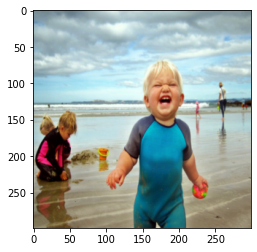

young boy holding frisbee <END>
young boy holding frisbee <END>
young boy holding frisbee <END>
young boy holding frisbee <END>


In [ ]:
!wget https://hochu.ua/images/140215471_0.jpg -O img.jpg
img = plt.imread('img.jpg')
img = misc.imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(4):
    print(model.generate_caption(img, t=5))

--2021-07-05 19:01:27--  https://meduza.io/image/attachments/images/006/773/478/large/26TqFxa7tbOTahfsDfKBNQ.jpg
Resolving meduza.io (meduza.io)... 163.172.74.46, 88.212.244.68, 88.212.240.172, ...
Connecting to meduza.io (meduza.io)|163.172.74.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 129712 (127K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 126.67K   343KB/s    in 0.4s    

2021-07-05 19:01:28 (343 KB/s) - ‘img.jpg’ saved [129712/129712]



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
    Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until


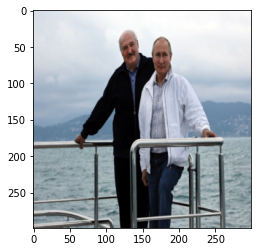

man standing bench <END>
man standing bench <END>
man standing bench <END>
man standing bench <END>


In [ ]:
!wget https://meduza.io/image/attachments/images/006/773/478/large/26TqFxa7tbOTahfsDfKBNQ.jpg -O img.jpg
img = plt.imread('img.jpg')
img = misc.imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(4):
    print(model.generate_caption(img, t=7))

--2021-07-05 18:56:20--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 104.239.249.248
Connecting to ccanimalclinic.com (ccanimalclinic.com)|104.239.249.248|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [following]
--2021-07-05 18:56:20--  https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Connecting to ccanimalclinic.com (ccanimalclinic.com)|104.239.249.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 104.37K   575KB/s    in 0.2s    

2021-07-05 18:56:20 (575 KB/s) - ‘img.jpg’ saved [106870/106870]



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
    Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until


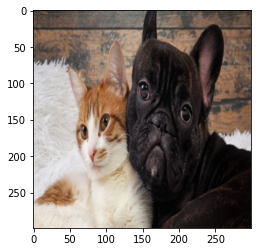

at sitting couch <END
at sitting couch <END
at sitting couch <END
at sitting couch <END


In [ ]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg
img = plt.imread('img.jpg')
img = misc.imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(4):
    print(model.generate_caption(img, t=1))

--2021-07-05 19:04:27--  https://bobr.by/data/health/image_409.jpg
Resolving bobr.by (bobr.by)... 185.47.152.250
Connecting to bobr.by (bobr.by)|185.47.152.250|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139459 (136K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 136.19K   400KB/s    in 0.3s    

2021-07-05 19:04:29 (400 KB/s) - ‘img.jpg’ saved [139459/139459]



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
    Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until


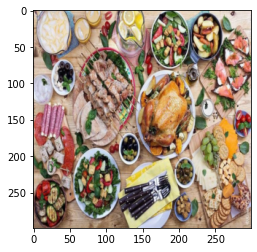

pizza pizza table <END>
pizza pizza table <END>
pizza pizza table <END>
pizza pizza table <END>


In [ ]:
!wget https://bobr.by/data/health/image_409.jpg -O img.jpg
img = plt.imread('img.jpg')
img = misc.imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(4):
    print(model.generate_caption(img, t=1))

## examples of model with attention

--2021-07-06 17:58:06--  https://bobr.by/data/health/image_409.jpg
Resolving bobr.by (bobr.by)... 185.47.152.250
Connecting to bobr.by (bobr.by)|185.47.152.250|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139459 (136K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 136.19K  --.-KB/s    in 0.06s   

2021-07-06 17:58:06 (2.20 MB/s) - ‘img.jpg’ saved [139459/139459]



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
    Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until


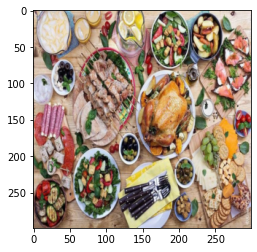

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


pizza pizza pizza pizza pizza pizza pizza pizza pizza pizza
pizza pizza pizza pizza pizza pizza pizza pizza pizza pizza
pizza pizza pizza pizza pizza pizza pizza pizza pizza pizza
pizza pizza pizza pizza pizza pizza pizza pizza pizza pizza


In [45]:
!wget https://bobr.by/data/health/image_409.jpg -O img.jpg
img = plt.imread('img.jpg')
img = misc.imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(4):
    print(model_2.generate_caption(img, t=1))

--2021-07-06 17:58:31--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 104.239.249.248
Connecting to ccanimalclinic.com (ccanimalclinic.com)|104.239.249.248|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [following]
--2021-07-06 17:58:31--  https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Connecting to ccanimalclinic.com (ccanimalclinic.com)|104.239.249.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 104.37K   429KB/s    in 0.2s    

2021-07-06 17:58:32 (429 KB/s) - ‘img.jpg’ saved [106870/106870]



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
    Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until


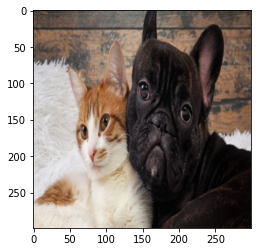

cat cat cat cat cat cat cat cat dog dog
cat cat cat cat cat cat cat cat dog dog
cat cat cat cat cat cat cat cat dog dog
cat cat cat cat cat cat cat cat dog dog


In [46]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg
img = plt.imread('img.jpg')
img = misc.imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(4):
    print(model_2.generate_caption(img))

--2021-07-06 17:59:07--  https://meduza.io/image/attachments/images/006/773/478/large/26TqFxa7tbOTahfsDfKBNQ.jpg
Resolving meduza.io (meduza.io)... 88.212.244.68, 88.212.240.172, 163.172.73.181, ...
Connecting to meduza.io (meduza.io)|88.212.244.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 129712 (127K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 126.67K  --.-KB/s    in 0.1s    

2021-07-06 17:59:07 (1.02 MB/s) - ‘img.jpg’ saved [129712/129712]



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
    Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until


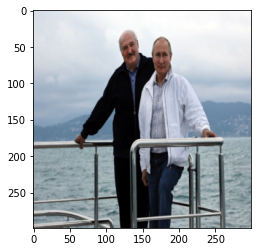

man man man boat boat boat boat boat boat <END>
man man man boat boat boat boat boat boat <END>
man man man boat boat boat boat boat boat <END>
man man man boat boat boat boat boat boat <END>


In [47]:
!wget https://meduza.io/image/attachments/images/006/773/478/large/26TqFxa7tbOTahfsDfKBNQ.jpg -O img.jpg
img = plt.imread('img.jpg')
img = misc.imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(4):
    print(model_2.generate_caption(img))

--2021-07-06 17:59:43--  https://hochu.ua/images/140215471_0.jpg
Resolving hochu.ua (hochu.ua)... 104.26.7.20, 104.26.6.20, 172.67.75.36, ...
Connecting to hochu.ua (hochu.ua)|104.26.7.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63888 (62K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  62.39K  --.-KB/s    in 0.006s  

2021-07-06 17:59:44 (9.47 MB/s) - ‘img.jpg’ saved [63888/63888]



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
    Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until


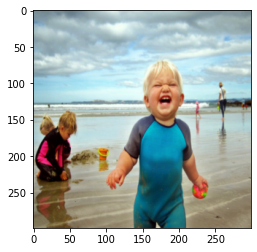

little boy boy boy beach beach beach beach beach beach
little boy boy boy beach beach beach beach beach beach
little boy boy boy beach beach beach beach beach beach
little boy boy boy beach beach beach beach beach beach


In [48]:
!wget https://hochu.ua/images/140215471_0.jpg -O img.jpg
img = plt.imread('img.jpg')
img = misc.imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(4):
    print(model_2.generate_caption(img))

#Results

Here you can see the result of two models. 

Both experiments and graphs can be found here:

 [model without attention](https://wandb.ai/miana/image_captioning/reports/Report-Model-without-attention--Vmlldzo4Mjc3MTA)

[model with attention](https://wandb.ai/miana/attention/reports/Model-with-attention---Vmlldzo4MzAzNjY)

Some ideas to improve the work: 
- add schedulers to control learning rate 
- use not only greedy search, but also beam search with penalties on word repetition (as it was seen on results of model with attention) 
- use temperature in generation 
- add other data and preprocessing with bert

In [ ]:
import pandas as pd
report = np.array([[model_loss, model_bleu, model_meteor, model_rouge_bi, model_rouge_uni], [model_2_loss, model_2_bleu, model_2_meteor, model_2_rouge_bi, model_2_rouge_uni]])
columns = ["loss", "bleu", "meteor", "rouge bigrams", "rouge unigrams"]
indexes = ["model without attention", "model with attention"]

frame = pd.DataFrame(data=report, columns=columns, index=indexes)

In [ ]:
frame

,loss,bleu,meteor,rouge bigrams,rouge unigrams
model without attention,4.361531,0.342113,0.072126,0.012234,0.069005
model with attention,4.345201,0.343704,0.067927,0.012766,0.074745


In total models did not show much difference, but it is believed that model with attention has high perspective in more training epochs. 